# Data Preparation

## load data

In [7]:
import pandas as pd

# pd.options.mode.copy_on_write = True

YEARS = [2023]
TZ = 'Europe/Berlin'

FILE_PATH = f'data_Energy_Germany/Realised_Demand_Germany_{YEARS[0]}.csv'

def load_data():
    df = pd.read_csv(FILE_PATH, sep=';')
    
    df.drop(['Residual Load [MWh]', 'Pumped Storage [MWh]', 'Date to'], axis=1, inplace=True)
    df.rename(columns={'Date from': 'date_from', 'Total (Grid Load) [MWh]': 'grid_load'}, inplace=True)
    
    # convert to datetime columns
    df['date_from'] = pd.to_datetime(df['date_from'], format='%d.%m.%y %H:%M').dt.tz_localize(TZ, ambiguous='infer')
    
    # convert to float column
    df.grid_load = df.grid_load.str.replace('.', '').str.replace(',', '.')  # clean float representation
    df = df.astype({'grid_load': float})

    # report NAs
    for col in df.columns:
        if any(df.date_from.isna()):
            print(f'WARNING: Missing value in column {col} detected!')
    return df

df = load_data()
df.head()

,date_from,grid_load
0,2023-01-01 00:00:00+01:00,9720.75
1,2023-01-01 00:15:00+01:00,9641.25
2,2023-01-01 00:30:00+01:00,9609.50
3,2023-01-01 00:45:00+01:00,9565.00
4,2023-01-01 01:00:00+01:00,9473.50


In [8]:
GRID_LOAD_DICT = dict(zip(df.date_from, df.grid_load))

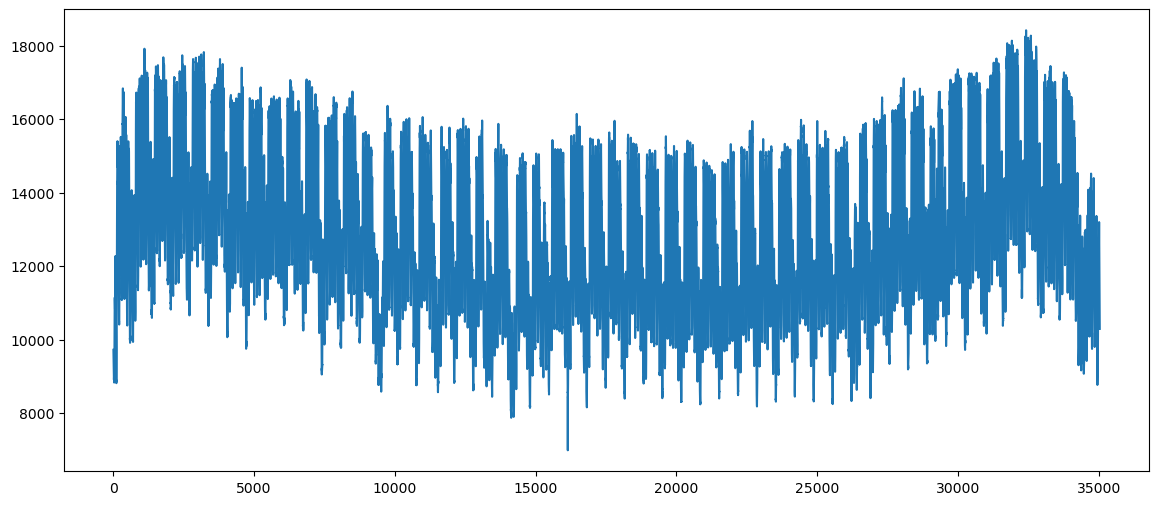

In [9]:
# PLOT DATA

import numpy as np
import matplotlib.pyplot as plt

def plot_data(df):
    data = np.array(df.grid_load)
    
    fig, ax = plt.subplots(figsize=(14,6))
    ax.plot(np.arange(data.size), data)
    plt.show()

plot_data(df)

## categorize days

In [10]:
from holidays.utils import country_holidays

def categorize_days(df):
    german_holidays = country_holidays('DE', years=YEARS)
    holiday_dates = set(german_holidays.keys())
    
    def is_sunday_or_holiday(timestamp):
        return timestamp.date() in holiday_dates or timestamp.day_name() == 'Sunday'
    
    def gen_saturday_col(df):
        return df.date_from.map(lambda ts: ts.day_name() == 'Saturday') & ~df.is_sunday_or_holiday
    
    df = df.assign(is_sunday_or_holiday=df.date_from.map(is_sunday_or_holiday))
    df = df.assign(is_saturday_and_not_holiday=gen_saturday_col(df))
    df = df.assign(is_workday=(~df.is_sunday_or_holiday & ~df.is_saturday_and_not_holiday))
    return df

df = categorize_days(df)
df.head()

,date_from,grid_load,is_sunday_or_holiday,is_saturday_and_not_holiday,is_workday
0,2023-01-01 00:00:00+01:00,9720.75,True,False,False
1,2023-01-01 00:15:00+01:00,9641.25,True,False,False
2,2023-01-01 00:30:00+01:00,9609.50,True,False,False
3,2023-01-01 00:45:00+01:00,9565.00,True,False,False
4,2023-01-01 01:00:00+01:00,9473.50,True,False,False


## add heating period

In [14]:
def add_heating_period(df):
    # heating period is approx. from October to March, i.e. not April (4) to September (9)
    df = df.assign(is_heating_period=df.date_from.map(lambda ts: ts.month not in range(4, 9+1)))
    return df

df = add_heating_period(df)
df.head()

AttributeError: 'NoneType' object has no attribute 'assign'

## add lagged time stamps

In [13]:
from datetime import timedelta


def add_lagged_ts(df, df_points_per_hour=4):
    def sub_one_week(ts):
        return add_timedelta(ts, timedelta(weeks=-1))
    
    def sub_one_year(ts):
        # todo: decide how to handle leap years
        return add_timedelta(ts, timedelta(days=-365))
    
    def add_timedelta(ts, td):
        # based on: https://www.hacksoft.io/blog/handling-timezone-and-dst-changes-with-python
        ts_utc = ts.astimezone('UTC')
        ts_next_week_utc = ts_utc + td
        ts_next_week = ts_next_week_utc.astimezone(TZ)
        dst_offset_diff = ts.dst() - ts_next_week.dst()
        ts_next_week += dst_offset_diff
        return ts_next_week
    
    df.rename(columns={'date_from': 'ts_pred', 'grid_load': 'load_to_pred'}, inplace=True)
    
    # account for DST changes for lags >= 1d
    df = df.assign(ts_last_week=df.ts_pred.map(sub_one_week))
    
    # ignore DST changes for lags <= 1h
    df = df.assign(ts_last_15_minutes=df.ts_pred.shift(1))
    df = df.assign(ts_last_hour=df.ts_pred.shift(df_points_per_hour))
    
    df.dropna(inplace=True, ignore_index=True)
    return df

add_lagged_ts(df).head()
# df = add_lagged_ts(df)
# df.head()

AttributeError: 'NoneType' object has no attribute 'rename'

## remove OOB timestamps (due to shifting)

In [24]:
def remove_oob_ts(df):
    ts_with_data_min, ts_with_data_max = df.ts_pred.min(), df.ts_pred.max()
    
    for col in ['ts_last_week', 'ts_last_15_minutes', 'ts_last_hour']:
        out_of_bounds_index = df[(df[col] < ts_with_data_min) | (df[col] > ts_with_data_max)].index
        df.drop(index=out_of_bounds_index, inplace=True)
    return df

df = remove_oob_ts(df)
df

,ts_pred,load_to_pred,is_sunday_or_holiday,is_saturday_and_not_holiday,is_workday,is_heating_period,ts_last_week,ts_last_15_minutes,ts_last_hour
672,2023-01-08 01:00:00+01:00,10375.25,True,False,False,True,2023-01-01 01:00:00+01:00,2023-01-08 00:45:00+01:00,2023-01-08 00:00:00+01:00
673,2023-01-08 01:15:00+01:00,10232.75,True,False,False,True,2023-01-01 01:15:00+01:00,2023-01-08 01:00:00+01:00,2023-01-08 00:15:00+01:00
674,2023-01-08 01:30:00+01:00,10189.25,True,False,False,True,2023-01-01 01:30:00+01:00,2023-01-08 01:15:00+01:00,2023-01-08 00:30:00+01:00
675,2023-01-08 01:45:00+01:00,10119.50,True,False,False,True,2023-01-01 01:45:00+01:00,2023-01-08 01:30:00+01:00,2023-01-08 00:45:00+01:00
676,2023-01-08 02:00:00+01:00,10070.50,True,False,False,True,2023-01-01 02:00:00+01:00,2023-01-08 01:45:00+01:00,2023-01-08 01:00:00+01:00
...,...,...,...,...,...,...,...,...,...
35031,2023-12-31 22:45:00+01:00,10782.00,True,False,False,True,2023-12-24 22:45:00+01:00,2023-12-31 22:30:00+01:00,2023-12-31 21:45:00+01:00
35032,2023-12-31 23:00:00+01:00,10753.75,True,False,False,True,2023-12-24 23:00:00+01:00,2023-12-31 22:45:00+01:00,2023-12-31 22:00:00+01:00
35033,2023-12-31 23:15:00+01:00,10606.75,True,False,False,True,2023-12-24 23:15:00+01:00,2023-12-31 23:00:00+01:00,2023-12-31 22:15:00+01:00
35034,2023-12-31 23:30:00+01:00,10495.75,True,False,False,True,2023-12-24 23:30:00+01:00,2023-12-31 23:15:00+01:00,2023-12-31 22:30:00+01:00


## timestamps to grid loads

In [27]:
def ts_to_loads(df):
    df = df.assign(load_last_week=df.ts_last_week.map(lambda ts: grid_load_dict[ts]))
    df = df.assign(load_last_hour=df.ts_last_hour.map(lambda ts: grid_load_dict[ts]))
    df = df.assign(load_last_15_minutes=df.ts_last_15_minutes.map(lambda ts: grid_load_dict[ts]))
    
    # remove unneeded time stamp columns
    df.drop(['ts_last_week', 'ts_last_hour', 'ts_last_15_minutes'], axis=1, inplace=True)
    return df

df = ts_to_loads(df)
df

,ts_pred,load_to_pred,is_sunday_or_holiday,is_saturday_and_not_holiday,is_workday,is_heating_period,load_last_week,load_last_hour,load_last_15_minutes
672,2023-01-08 01:00:00+01:00,10375.25,True,False,False,True,9473.50,10807.25,10510.25
673,2023-01-08 01:15:00+01:00,10232.75,True,False,False,True,9448.00,10703.75,10375.25
674,2023-01-08 01:30:00+01:00,10189.25,True,False,False,True,9550.25,10627.00,10232.75
675,2023-01-08 01:45:00+01:00,10119.50,True,False,False,True,9463.75,10510.25,10189.25
676,2023-01-08 02:00:00+01:00,10070.50,True,False,False,True,9358.50,10375.25,10119.50
...,...,...,...,...,...,...,...,...,...
35031,2023-12-31 22:45:00+01:00,10782.00,True,False,False,True,11116.00,11134.50,11008.50
35032,2023-12-31 23:00:00+01:00,10753.75,True,False,False,True,11023.50,11191.50,10782.00
35033,2023-12-31 23:15:00+01:00,10606.75,True,False,False,True,10856.25,11117.25,10753.75
35034,2023-12-31 23:30:00+01:00,10495.75,True,False,False,True,10688.25,11008.50,10606.75


In [28]:
def save_df(df, filename='data.pkl'):
    df.to_pickle(filename)

save_df(df)

# Linear Regression

## load data

In [32]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split

from energy_test import df_to_input_output

# prepare data

df = pd.read_pickle('data.pkl')
X, y = df_to_input_output(df)  # convert df to np arrays
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17182, 7), (17182, 7), (17182, 1), (17182, 1))

## Run LinReg

In [33]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print(f"Mean squared error relative to mean true value: {mean_squared_error(y_test, y_pred) / y_test.mean():.5f}")

Mean squared error relative to mean true value: 0.68747


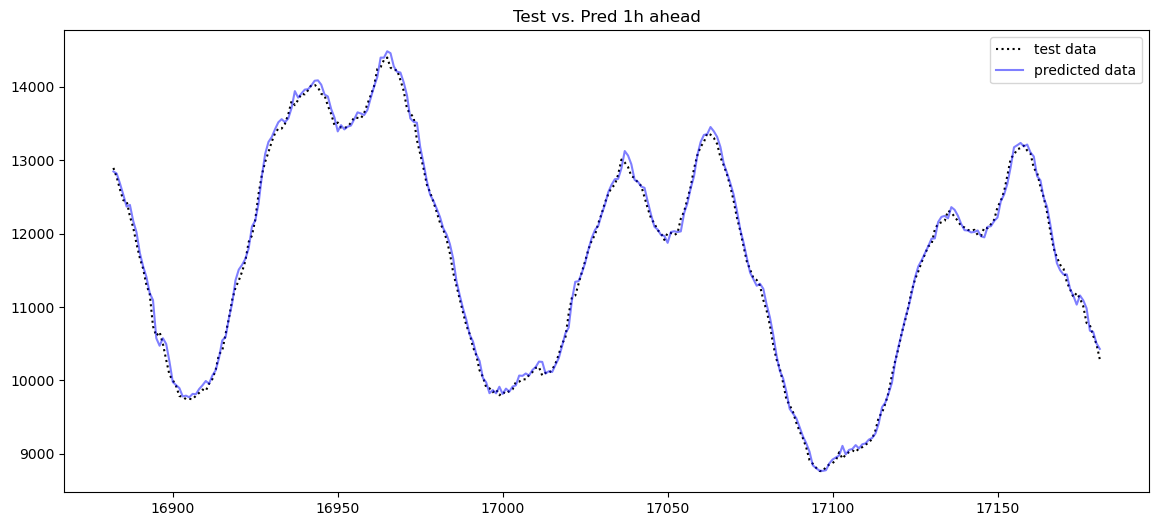

In [34]:
# %matplotlib widget

n_points = 300

fig, ax = plt.subplots(figsize=(14,6))

x_plot = np.arange(X_test.shape[0])

ax.plot(x_plot[-n_points:], y_test[-n_points:], color="black", label='test data', linestyle='dotted')
ax.plot(x_plot[-n_points:], y_pred[-n_points:], color="blue", label='predicted data', alpha=0.5)
plt.title('Test vs. Pred 1h ahead')
plt.legend()
plt.show()